In [872]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
#from keras.preprocessing import sequence, text
#from keras.layers import Input, Embedding
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

from nltk import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedKFold
import matplotlib.pyplot as plt
import lightgbm as lgb

#from keras.models import Sequential
#from keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from keras.wrappers.scikit_learn import KerasRegressor
from kerastuner.engine.hyperparameters import HyperParameters
from keras import backend as K
from keras.optimizers import Adam, SGD

import datetime as dt
import pandas as pd
import numpy as np
import warnings
import string

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [658]:
df = pd.read_excel('train_final.xlsx')

In [659]:
df = df.iloc[:,1:]

In [661]:
# entire data

X = df.drop(['project_is_approved'],axis = 1).iloc[:,:]
y = df.iloc[:,4]

In [671]:
# With inbalanced data (the ratio of 0 and 1 is 1:5), we selected part of the dataset in a ratio of 1:2

not_approved = df.iloc[df[df['project_is_approved'] == 0].index,:]
approved = df[df['project_is_approved'] == 1].sample(not_approved.shape[0]*2)

df_equal = pd.concat([not_approved,approved])


[ 0.         -0.          0.          0.01964649 -0.01377681 -0.01095572
 -0.04437254 -0.01016996  0.01303331  0.          0.         -0.
  0.          0.          0.          0.03317834  0.02135133  0.
 -0.          0.          0.          0.         -0.         -0.
  0.02528828  0.00611332  0.          0.          0.          0.00323853
 -0.00446619  0.          0.00406293 -0.00753784  0.          0.
  0.         -0.         -0.          0.00095146 -0.         -0.
 -0.00146417  0.          0.01765693 -0.          0.00285189  0.01019425
  0.          0.0022613  -0.         -0.         -0.00013585  0.
  0.00196919 -0.          0.0021633   0.00048937  0.         -0.00270267
  0.00369629 -0.         -0.        ]


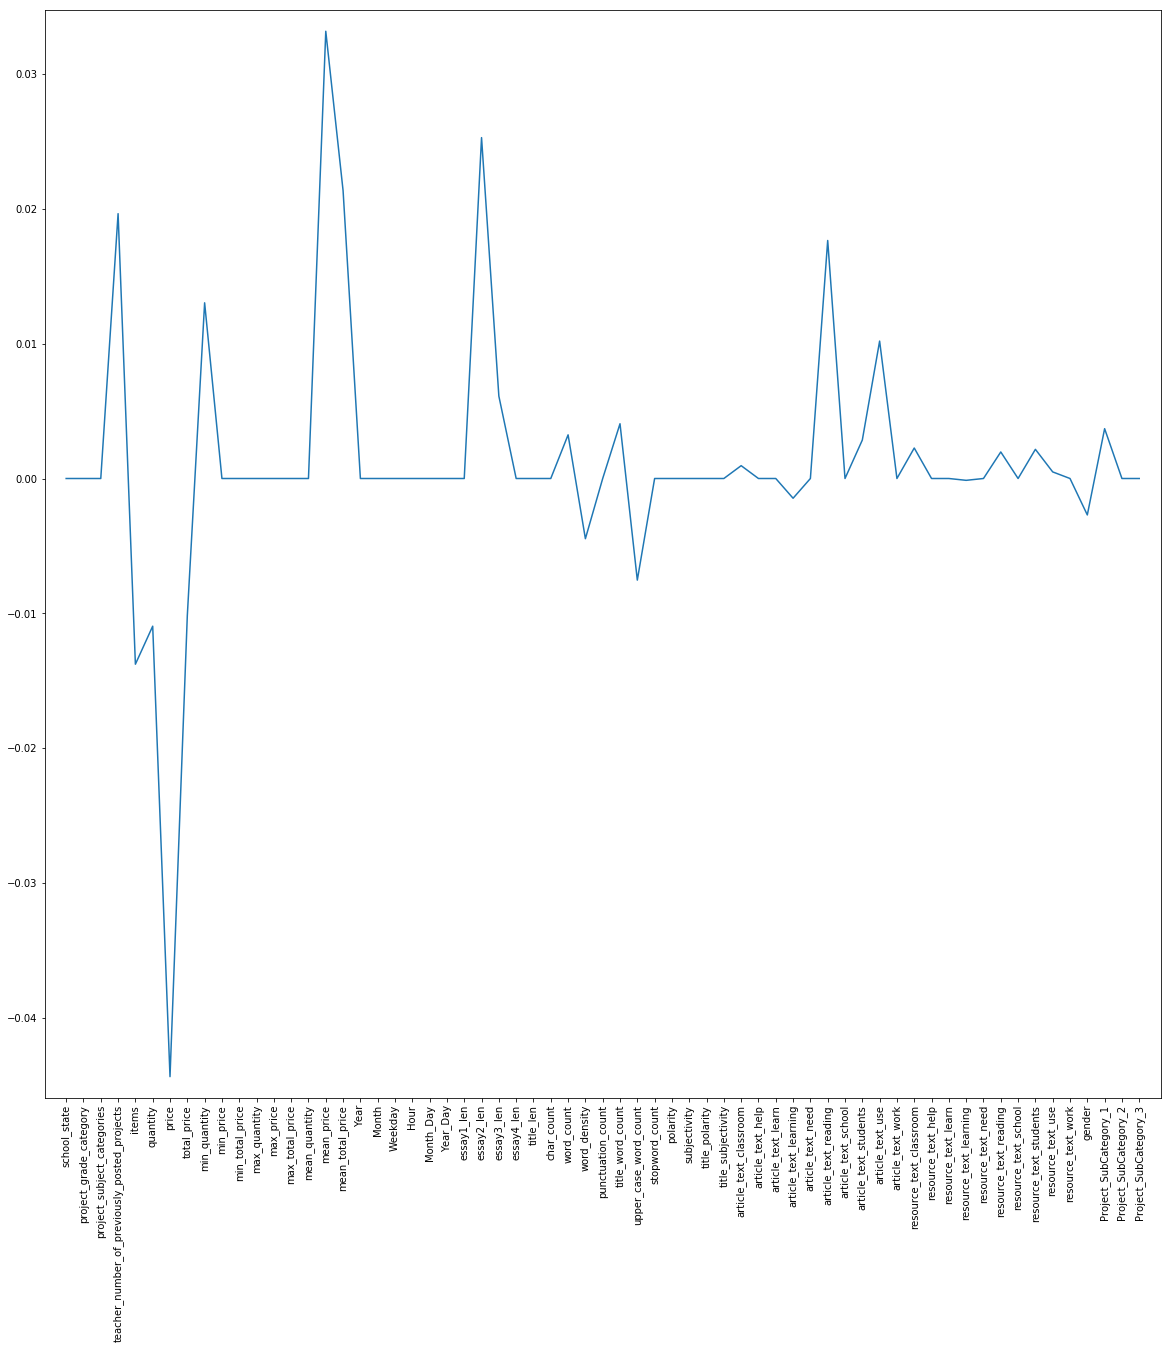

In [558]:
# Feature selection

scaler = StandardScaler()

X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42, stratify = y)

lasso = Lasso(alpha = 1e-5, normalize=True)


lasso.fit(X,y)

lasso_coef = lasso.fit(X,y).coef_
print(lasso_coef)

# Plot the coefficients
plt.figure(figsize = (20,20))
plt.plot(range(63), lasso_coef)
#plt.xticks(range(len(X.columns)), X.columns.values, rotation=60)
plt.margins(0.02)
#plt.figure(figsize = (20,20))
plt.xticks(range(63),('school_state', 'project_grade_category', 'project_subject_categories',
       'teacher_number_of_previously_posted_projects', 
       'items', 'quantity', 'price', 'total_price', 'min_quantity',
       'min_price', 'min_total_price', 'max_quantity', 'max_price',
       'max_total_price', 'mean_quantity', 'mean_price', 'mean_total_price',
       'Year', 'Month', 'Weekday', 'Hour', 'Month_Day', 'Year_Day',
       'essay1_len', 'essay2_len', 'essay3_len', 'essay4_len', 'title_len',
       'char_count', 'word_count', 'word_density', 'punctuation_count',
       'title_word_count', 'upper_case_word_count', 'stopword_count',
       'polarity', 'subjectivity', 'title_polarity', 'title_subjectivity',
       'article_text_classroom', 'article_text_help', 'article_text_learn',
       'article_text_learning', 'article_text_need', 'article_text_reading',
       'article_text_school', 'article_text_students', 'article_text_use',
       'article_text_work', 'resource_text_classroom', 'resource_text_help',
       'resource_text_learn', 'resource_text_learning', 'resource_text_need',
       'resource_text_reading', 'resource_text_school',
       'resource_text_students', 'resource_text_use', 'resource_text_work',
       'gender', 'Project_SubCategory_1', 'Project_SubCategory_2',
       'Project_SubCategory_3'), rotation=90)
plt.show()

## Ada Boosting

In [873]:
X = df_equal[['teacher_number_of_previously_posted_projects','items', 'quantity',
              'price','total_price','min_quantity', 
              'mean_price','mean_total_price','essay2_len','essay3_len','word_count',
              'word_density','title_word_count','upper_case_word_count',
              'article_text_classroom','article_text_learning','article_text_reading','article_text_students',
              'article_text_use','resource_text_classroom','resource_text_reading','resource_text_students',
              'gender','Project_SubCategory_1']].iloc[:,:]
y = df_equal.iloc[:,4]

In [874]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42, stratify = y)

In [875]:
dtc_params = {'base_estimator__max_depth':[5,10,15], 'base_estimator__min_samples_leaf':[15,20,25]}
dtc = DecisionTreeClassifier()

abc = AdaBoostClassifier(n_estimators = 30, base_estimator = dtc, learning_rate = 0.7)
abc_g = GridSearchCV(estimator = abc, param_grid = dtc_params, cv=2, n_jobs=-1, scoring='roc_auc')

abc_g.fit(X_train, y_train)
y_pred = abc_g.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

print("The AUC is:", auc(fpr, tpr))
print("")
print(classification_report(y_test, y_pred))

The AUC is: 0.6191151191241687

              precision    recall  f1-score   support

           0       0.57      0.39      0.46     11094
           1       0.74      0.85      0.79     22187

    accuracy                           0.70     33281
   macro avg       0.65      0.62      0.62     33281
weighted avg       0.68      0.70      0.68     33281



## LightGBM Classifier

In [739]:
X = df_equal[['teacher_number_of_previously_posted_projects','items', 'quantity',
              'price','total_price','min_quantity', 
              'mean_price','mean_total_price','essay2_len','essay3_len','word_count',
              'word_density','title_word_count','upper_case_word_count',
              'article_text_classroom','article_text_learning','article_text_reading','article_text_students',
              'article_text_use','resource_text_classroom','resource_text_reading','resource_text_students',
              'gender','Project_SubCategory_1']].iloc[:,:]
y = df_equal.iloc[:,4]

In [740]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42, stratify = y)

In [741]:
param_lgb = {'max_depth': range(1,10),
             'num_leaves': range(5,60),
             'min_data_in_leaf': range(5,20),
             'learning_rate':np.logspace(-4,0,10),
             'min_split_gain':np.logspace(-2,0,5),
             'boosting_type':['gbdt','dart','goss'],
             'n_estimators':np.arange(100,300)}

estimator = lgb.LGBMClassifier()

inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

gbm = RandomizedSearchCV(estimator, param_lgb, cv=inner_cv)
gbm_score = cross_val_score(gbm, X=X_train, y=y_train, cv=outer_cv, scoring='roc_auc')

In [742]:
gbm_score

array([0.72599492, 0.7133631 , 0.73120402, 0.71919766])

In [743]:
y_pred_gbm = gbm.fit(X_train,y_train).predict_proba(X_test)

In [744]:
y_pred_gbm

array([[0.12646003, 0.87353997],
       [0.12233975, 0.87766025],
       [0.56518707, 0.43481293],
       ...,
       [0.2802735 , 0.7197265 ],
       [0.43987652, 0.56012348],
       [0.53541213, 0.46458787]])

In [745]:
roc_auc_score(y_test, y_pred_gbm[:,1])

0.7244820195228474

In [626]:
gbm.best_params_

{'num_leaves': 39,
 'n_estimators': 116,
 'min_split_gain': 1.0,
 'min_data_in_leaf': 16,
 'max_depth': 7,
 'learning_rate': 0.016681005372000592,
 'boosting_type': 'dart'}

## XGboost Classifier

In [954]:
X = df_equal[['teacher_number_of_previously_posted_projects','items', 'quantity',
              'price','total_price','min_quantity', 
              'mean_price','mean_total_price','essay2_len','essay3_len','word_count',
              'word_density','title_word_count','upper_case_word_count',
              'article_text_classroom','article_text_learning','article_text_reading','article_text_students',
              'article_text_use','resource_text_classroom','resource_text_reading','resource_text_students',
              'gender','Project_SubCategory_1']].iloc[:,:]
y = df_equal.iloc[:,4]

In [955]:
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42, stratify = y)

In [956]:
kf = KFold(n_splits = 4, random_state = 42, shuffle = True)

In [962]:
# tune the best parameters on kaggle kernel 

import xgboost as xgb
cv_scores = []
xgb_preds = []

for train_index, test_index in kf.split(X):
    
    # Split out a validation set
    X_train1, X_valid1, y_train1, y_valid1 = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
    
    # params are tuned with kaggle kernels in mind
    xgb_params = {'eta': 0.09, 
                  'max_depth': 4, 
                  'subsample': 0.8, 
                  'colsample_bytree': 0.8, 
                  'objective': 'binary:logistic', 
                  'eval_metric': 'auc',
                  'gamma':5
                 }
    
    d_train = xgb.DMatrix(X_train1, y_train1)
    d_valid = xgb.DMatrix(X_valid1, y_valid1)
    d_test = xgb.DMatrix(X_test)
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb = xgb.train(xgb_params, d_train, 2000, watchlist, verbose_eval=50, early_stopping_rounds=30)
    cv_scores.append(float(xgb.attributes()['best_score']))
    xgb_pred = xgb.predict(d_test)
    xgb_preds.append(list(xgb_pred))
    
    del X_train1, X_valid1, y_train1, y_valid1, d_train, d_valid, d_test;

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.689332	valid-auc:0.696716
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 30 rounds.
[50]	train-auc:0.731783	valid-auc:0.731295
[100]	train-auc:0.741403	valid-auc:0.733962
[150]	train-auc:0.747591	valid-auc:0.734408
[200]	train-auc:0.752944	valid-auc:0.734747
[250]	train-auc:0.75805	valid-auc:0.734681
Stopping. Best iteration:
[269]	train-auc:0.759624	valid-auc:0.734908

[0]	train-auc:0.689332	valid-auc:0.696716
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 30 rounds.
[50]	train-auc:0.731783	valid-auc:0.731295
[100]	train-auc:0.741403	valid-auc:0.733962
[150]	train-auc:0.747591	valid-auc:0.734408
[200]	train-auc:0.752944	valid-auc:0.734747
[250]	train-auc:0.75805	valid-auc:0.734681
Stopping. Best iteration:
[269]	train-auc:0.759624	valid-auc:0.734908

[0]	train-auc:0.689332	valid-auc:0.696716
Multiple e

In [963]:
xgb_pred

array([0.89417136, 0.9083056 , 0.34058192, ..., 0.7405574 , 0.57599354,
       0.5114016 ], dtype=float32)

In [964]:
roc_auc_score(y_test,xgb_pred)

0.7578297851418457

## Decision Tree Classifier

In [596]:
X = df_equal[['teacher_number_of_previously_posted_projects','items', 'quantity',
              'price','min_quantity', 'min_price',
              'mean_price','mean_total_price','essay2_len','essay3_len','word_count',
              'word_density','title_word_count','upper_case_word_count',
              'article_text_classroom','article_text_learning','article_text_reading','article_text_students',
              'article_text_use','resource_text_classroom','resource_text_reading','resource_text_students',
              'gender','Project_SubCategory_1']].iloc[:,:]
y = df_equal.iloc[:,4]

In [597]:
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42, stratify = y)

In [598]:
tree = DecisionTreeClassifier()
p_grid = dict(max_depth = list(range(1,35)), min_samples_leaf=list(range(1,5)),criterion = ["gini","entropy"])
    
# Arrays to store scores - 10 is the number of random trials in
# the cross validation
    
# Choose cross-validation techniques for the inner and outer loops
# independently of the dataset.
# E.g "LabelKFold", "LeaveOneOut", "LeaveOneLabelOut", etc.
inner_cv = KFold(n_splits = 4, shuffle = True, random_state = 42)
outer_cv = KFold(n_splits = 4, shuffle = True, random_state = 42)
# Non_nested parameter search and scoring
tree_clf = RandomizedSearchCV(estimator = tree, param_distributions = p_grid, cv = inner_cv)
tree_clf_score = cross_val_score(tree_clf, X=X_train, y=y_train, cv=outer_cv, scoring='roc_auc')
print(tree_clf_score)

[0.69281641 0.62174656 0.68684768 0.69338204]


In [599]:
y_pred_tree = tree_clf.fit(X_train,y_train).predict_proba(X_test)

In [600]:
y_pred_tree[:,1]

array([0.80432645, 0.4375    , 0.53240279, ..., 0.4984127 , 0.73375   ,
       0.45979381])

In [601]:
roc_auc_score(y_test,y_pred_tree[:,1])

0.7053994352005203

## KNN Classifier

In [602]:
knn = KNeighborsClassifier()
param_knn = {'n_neighbors' : np.arange(3,10)}

inner_cv = KFold(n_splits = 4, shuffle = True, random_state = 42)
outer_cv = KFold(n_splits = 4, shuffle = True, random_state = 42)
        
#knn_clf = RandomizedSearchCV(estimator = knn, param_distributions = param_knn, cv = inner_cv)
knn_clf_score = cross_val_score(knn, X=X_train, y=y_train, cv=outer_cv,scoring = 'roc_auc')
print(knn_clf_score)

[0.6255053  0.62827765 0.62085856 0.62441682]


In [603]:
y_pred_knn = knn.fit(X_train,y_train).predict_proba(X_test)

In [604]:
roc_auc_score(y_test,y_pred_knn[:,1])

0.6325306221502238

## Logistic Regression

In [605]:
lg = LogisticRegression(solver = 'liblinear')
param_knn = {'penalty':['l1','l2'], 'C':np.logspace(-4,4,10)}

inner_cv = KFold(n_splits = 4, shuffle = True, random_state = 42)
outer_cv = KFold(n_splits = 4, shuffle = True, random_state = 42)

lg_cv = GridSearchCV(estimator = lg, param_grid = param_knn, cv = inner_cv)
lg_cv_score = cross_val_score(lg_cv, X=X_train, y=y_train, cv=outer_cv, scoring='roc_auc')
print(lg_cv_score)

[0.70754885 0.70540558 0.68679175 0.69912998]


In [606]:
y_pred_lg = lg_cv.fit(X_train,y_train).predict_proba(X_test)

In [607]:
roc_auc_score(y_test, y_pred_lg[:,1])

0.7014193578487669

In [608]:
lg_cv.best_estimator_

LogisticRegression(C=1291.5496650148827, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

## Neural Network

In [920]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units',min_value=32,
                                        max_value=256,
                                        step=32),
                           activation=hp.Choice('activation', values = ['tanh','relu'])))
    
    for i in range(hp.Int('num_layers', 1, 20)):
        model.add(layers.Dense(256, activation=hp.Choice('activation', values = ['tanh','relu'])))
        #model.add(layers.Dropout(0.4))
        
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model


In [921]:
X = df_equal[['teacher_number_of_previously_posted_projects','items', 'quantity',
              'price','min_quantity', 'min_price',
              'mean_price','mean_total_price','essay2_len','essay3_len','word_count',
              'word_density','title_word_count','upper_case_word_count',
              'article_text_classroom','article_text_learning','article_text_reading','article_text_students',
              'article_text_use','resource_text_classroom','resource_text_reading','resource_text_students',
              'gender','Project_SubCategory_1']].iloc[:,:]
y = df_equal.iloc[:,4]

In [922]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42, stratify = y)

In [923]:
y_train = y_train.values
y_test = y_test.values

In [924]:

tuner_rest = RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=2,
    executions_per_trial=3,
    project_name='test1')

tuner_rest.search(X_train, y_train,
             epochs=10,
             validation_split=0.1, verbose=2)

tuner_rest.results_summary()

INFO:tensorflow:Reloading Oracle from ./test1/oracle.json
Train on 44928 samples, validate on 4993 samples
Epoch 1/10
44928/44928 - 6s - loss: 0.5881 - accuracy: 0.6947 - val_loss: 0.5655 - val_accuracy: 0.7122
Epoch 2/10
44928/44928 - 5s - loss: 0.5699 - accuracy: 0.7074 - val_loss: 0.5697 - val_accuracy: 0.7128
Epoch 3/10
44928/44928 - 5s - loss: 0.5644 - accuracy: 0.7108 - val_loss: 0.5650 - val_accuracy: 0.7130
Epoch 4/10
44928/44928 - 5s - loss: 0.5606 - accuracy: 0.7138 - val_loss: 0.5671 - val_accuracy: 0.7134
Epoch 5/10
44928/44928 - 5s - loss: 0.5555 - accuracy: 0.7183 - val_loss: 0.5653 - val_accuracy: 0.7076
Epoch 6/10
44928/44928 - 5s - loss: 0.5494 - accuracy: 0.7216 - val_loss: 0.5752 - val_accuracy: 0.7134
Epoch 7/10
44928/44928 - 5s - loss: 0.5431 - accuracy: 0.7260 - val_loss: 0.5865 - val_accuracy: 0.6916
Epoch 8/10
44928/44928 - 5s - loss: 0.5343 - accuracy: 0.7318 - val_loss: 0.5798 - val_accuracy: 0.6970
Epoch 9/10
44928/44928 - 5s - loss: 0.5225 - accuracy: 0.7407

Train on 44928 samples, validate on 4993 samples
Epoch 1/10
44928/44928 - 10s - loss: 0.5874 - accuracy: 0.6924 - val_loss: 0.5720 - val_accuracy: 0.7046
Epoch 2/10
44928/44928 - 9s - loss: 0.5759 - accuracy: 0.7021 - val_loss: 0.5689 - val_accuracy: 0.7146
Epoch 3/10
44928/44928 - 9s - loss: 0.5732 - accuracy: 0.7057 - val_loss: 0.5668 - val_accuracy: 0.7168
Epoch 4/10
44928/44928 - 9s - loss: 0.5719 - accuracy: 0.7055 - val_loss: 0.5639 - val_accuracy: 0.7142
Epoch 5/10
44928/44928 - 9s - loss: 0.5708 - accuracy: 0.7060 - val_loss: 0.5636 - val_accuracy: 0.7146
Epoch 6/10
44928/44928 - 9s - loss: 0.5700 - accuracy: 0.7078 - val_loss: 0.5639 - val_accuracy: 0.7134
Epoch 7/10
44928/44928 - 9s - loss: 0.5690 - accuracy: 0.7084 - val_loss: 0.5658 - val_accuracy: 0.7076
Epoch 8/10
44928/44928 - 9s - loss: 0.5688 - accuracy: 0.7072 - val_loss: 0.5628 - val_accuracy: 0.7118
Epoch 9/10
44928/44928 - 9s - loss: 0.5675 - accuracy: 0.7087 - val_loss: 0.5636 - val_accuracy: 0.7114
Epoch 10/10
44

INFO:tensorflow:Oracle triggered exit


In [925]:
model = tuner_rest.get_best_models(num_models=1)[0]

In [927]:
y_pred_nn = model.predict(X_test)

In [928]:
roc_auc_score(y_test,y_pred_nn)

0.6921391734996779

## Output submission file

In [966]:
# best auc score is from xgboost model

In [830]:
test = pd.read_csv('test.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
test_id = test['id']

In [834]:
test = pd.read_excel('test_final.xlsx')

In [943]:
# select variables

test_x = test[['teacher_number_of_previously_posted_projects','items', 'quantity',
              'price','min_quantity', 'min_price',
              'mean_price','mean_total_price','essay2_len','essay3_len','word_count',
              'word_density','title_word_count','upper_case_word_count',
              'article_text_classroom','article_text_learning','article_text_reading','article_text_students',
              'article_text_use','resource_text_classroom','resource_text_reading','resource_text_students',
              'gender','Project_SubCategory_1']].iloc[:,:]

scaler = StandardScaler()
test_x = scaler.fit_transform(test_x)

In [948]:
# prediction

pred_y = xgb.predict_proba(test_x)
pred = pred_y[:,1]

In [950]:
# Output as CSV

pred = pd.DataFrame(pred)
pred.columns = ['project_is_approved']
sub = pd.concat([test_id, pred], axis=1)
sub.to_csv('xgb_submission.csv', index=False)